In [5]:
from sklearn.decomposition import PCA
from FileIO import FileIO
import matplotlib.pyplot as plt
import numpy as np
from PlotUtility import plot_multi_channel
from sklearn.metrics import mutual_info_score
from PlotUtility import plot_multi_channel
from scipy import signal
from sklearn.decomposition import FastICA
import scipy

def get_mutual_information(x,y):
    bins = np.linspace(-128.5,128,128*2+1)
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def time_delay_embed(x,ndelay=10,tau=1):
    nsample = len(x)
    final_length = nsample-ndelay*tau+1
    embeded_signal = []
    for i in range(ndelay):
        embeded_signal.append(x[i*tau:i*tau+final_length])
    return np.vstack(embeded_signal)

def find_time_delay_MI(x,ndelay = 50,tau = 1):
    embedding = time_delay_embed(x,ndelay=ndelay,tau=tau)
    mis = []
    for i in range(ndelay-1):
        mis.append(get_mutual_information(embedding[0],embedding[i+1]))
    return(mis)


In [6]:
io = FileIO()
exps = io.load_experiment('s1')
emg = exps['S1_E1_A1']['emg'].astype(int)

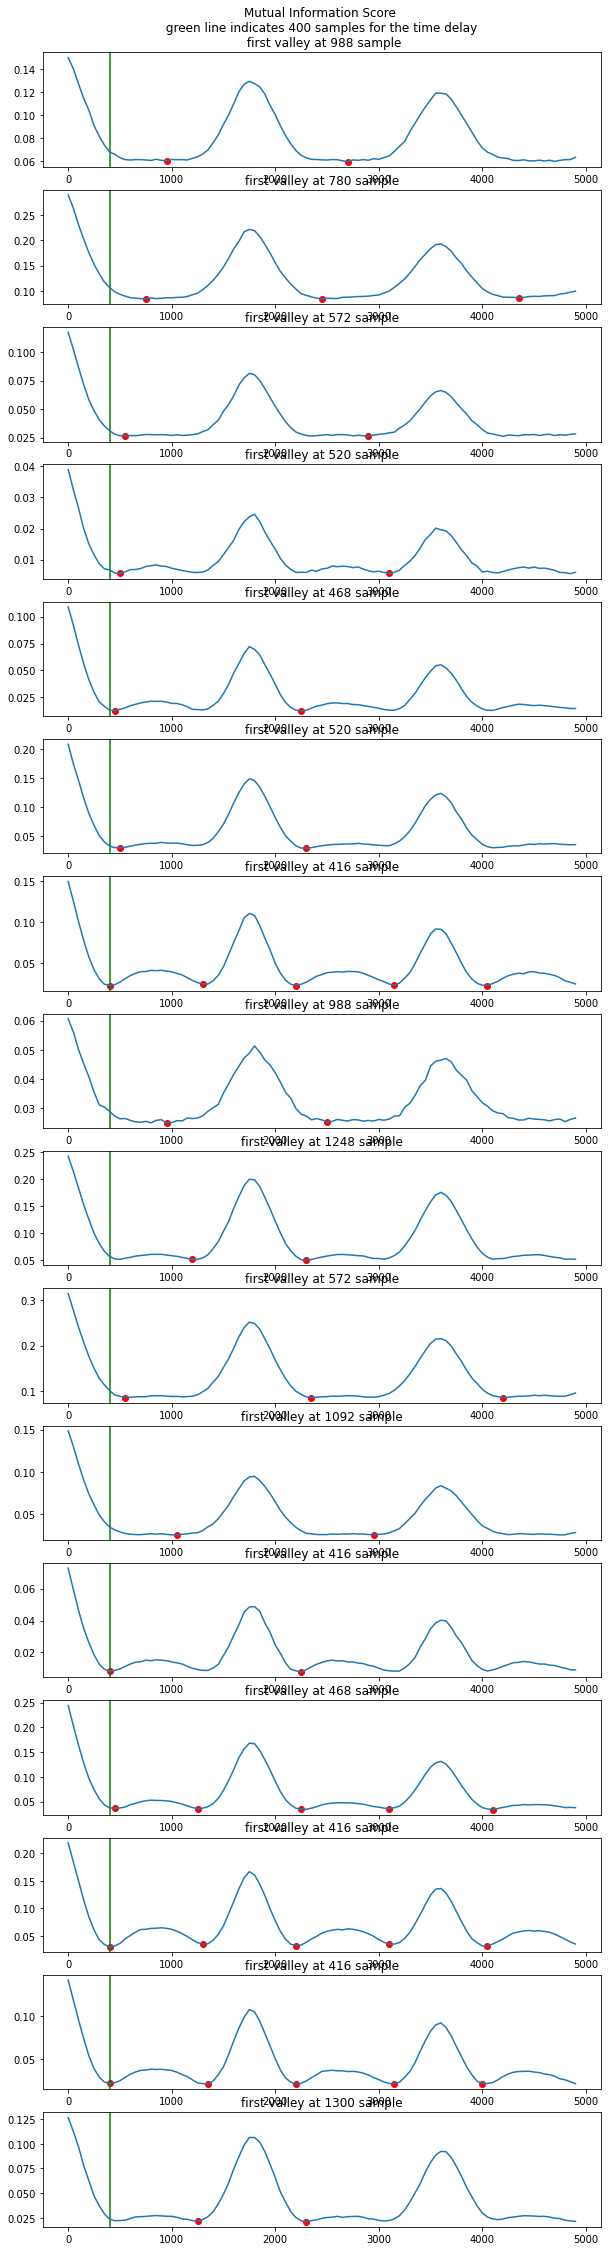

In [7]:
mis = []
for i in range(16):
    mi = find_time_delay_MI(emg[:,i],ndelay = 100,tau = 50)
    mis.append(mi)
mis=np.array(mis)
plt.figure(figsize = [10,5*8])
for i in range(16):
    plt.subplot(16,1,i+1)
    mi = mis[i]
    peaks,_ = signal.find_peaks(-mi,prominence=0.01)
    plt.scatter(peaks*50,mi[peaks],c='r')
    if i==0:
        plt.title(f'Mutual Information Score \n green line indicates 400 samples for the time delay \n first valley at {peaks[0]*52} sample')
    else:
        plt.title(f'first valley at {peaks[0]*52} sample')
    plt.axvline(400,color = 'g')
    plt.plot(np.array(range(len(mi)))*50,mi)

In [8]:
phase_space_reconstruction = []
for i in range(16):
    phase_space_reconstruction.append(time_delay_embed(emg[:,i],ndelay = 7,tau = 400))
phase_space_reconstruction = np.vstack(phase_space_reconstruction)
print(f'The reconstructed phase space has {phase_space_reconstruction.shape[0]} dimensions with {phase_space_reconstruction.shape[1]} time samples each')

The reconstructed phase space has 112 dimensions with 127468 time samples each


first 76 principle components catpures 95 percent of all variances


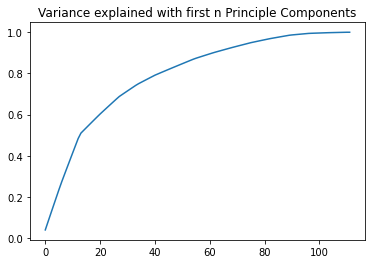

In [11]:
pca = PCA(svd_solver='auto')
pca.fit(phase_space_reconstruction)
plt.title('Variance explained with first n Principle Components')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print(f'first {np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0]} principle components catpures 95 percent of all variances')

In [12]:
pc = pca.transform(phase_space_reconstruction)
reconstruction = pc[:76,:]
transformer = FastICA(random_state=0)
X_transformed = transformer.fit_transform(reconstruction.T)

In [15]:
# time_dependent_sources = pickle.load(open('source signals from emg data_tau.pkl','rb'))
gloves = emg = exps['S1_E1_A1']['glove']
# rectified = np.abs(time_dependent_sources)
# power = []
# for i in range(rectified.shape[1]):
#     power.append(gaussian_filter1d(rectified[:,i],sigma = 50))
# power = np.array(power).T
# power = normalize(power,axis = 0)
# gloves = normalize(gloves,axis = 0)

Here is the cyberglove signal for the trial from 3 channels out of 22

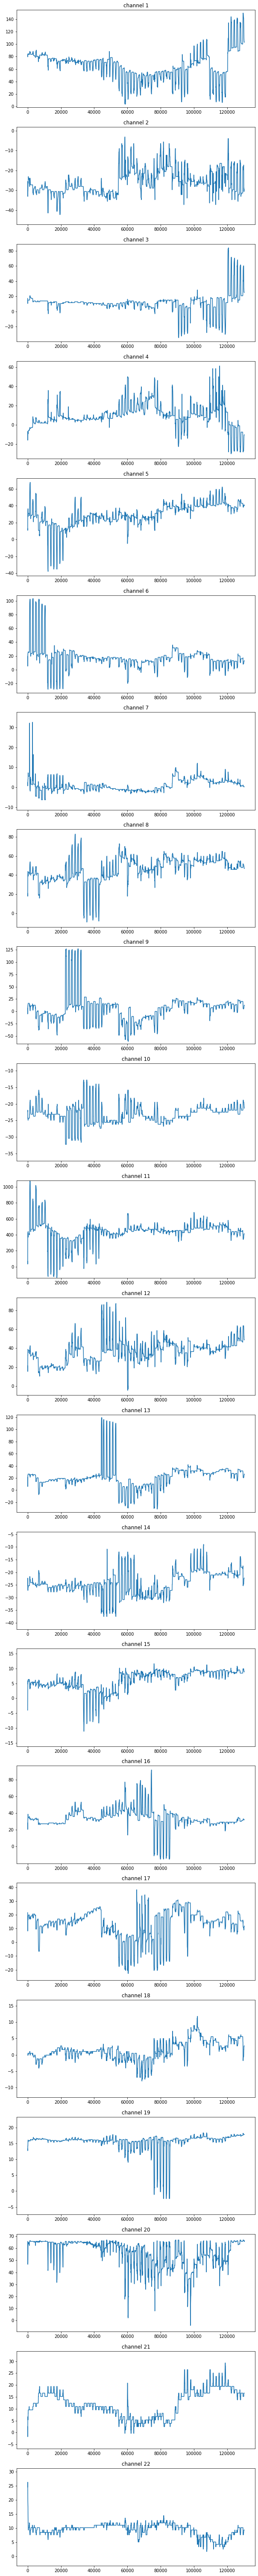

In [18]:
plot_multi_channel(gloves,titles = ['channel ' +str(i+1) for i in range(22)])

In [18]:
ndim_gloves = gloves.shape[1]
ndim_power = power.shape[1]
correlation = np.zeros([ndim_gloves,ndim_power])
stats = np.zeros([ndim_gloves,ndim_power])
for i in range(ndim_gloves):
    for j in range(ndim_power):
        x = gloves[:,i]
        y = power[:,j]
        correlation[i,j],stats[i,j] = scipy.stats.pearsonr(x,y)

As not all of the channels in the cyberglove recorded siginificant joint movement in this trial, we focused on one of the channel: channel 5 that displayed perodic movements.  This channel mapes the knuckle joint of the index finger.

Below, 10 of the sources with significant p values are shown.

Orange is the cyberglove recording from channel 5

Green is the power calculated for the source signal

blue is the source signal itself.

As we can see, The sources exhibited a range of patterns with regards to the joint angle, including **slightly preceeding, co-occuring and persistant activation after joint movement**.

This could reponding to muscles that **initiates, finishes the movement and maintains** the finger posture.

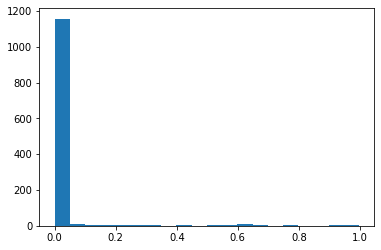

In [38]:
plt.hist(stats.flatten(),bins = 20);

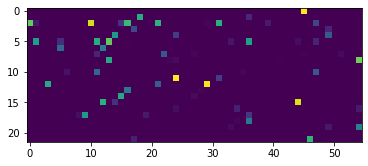

In [39]:
plt.imshow(stats)

In [24]:
sum(ch5_correlates)

50

In [25]:
len(correlation[5])

55

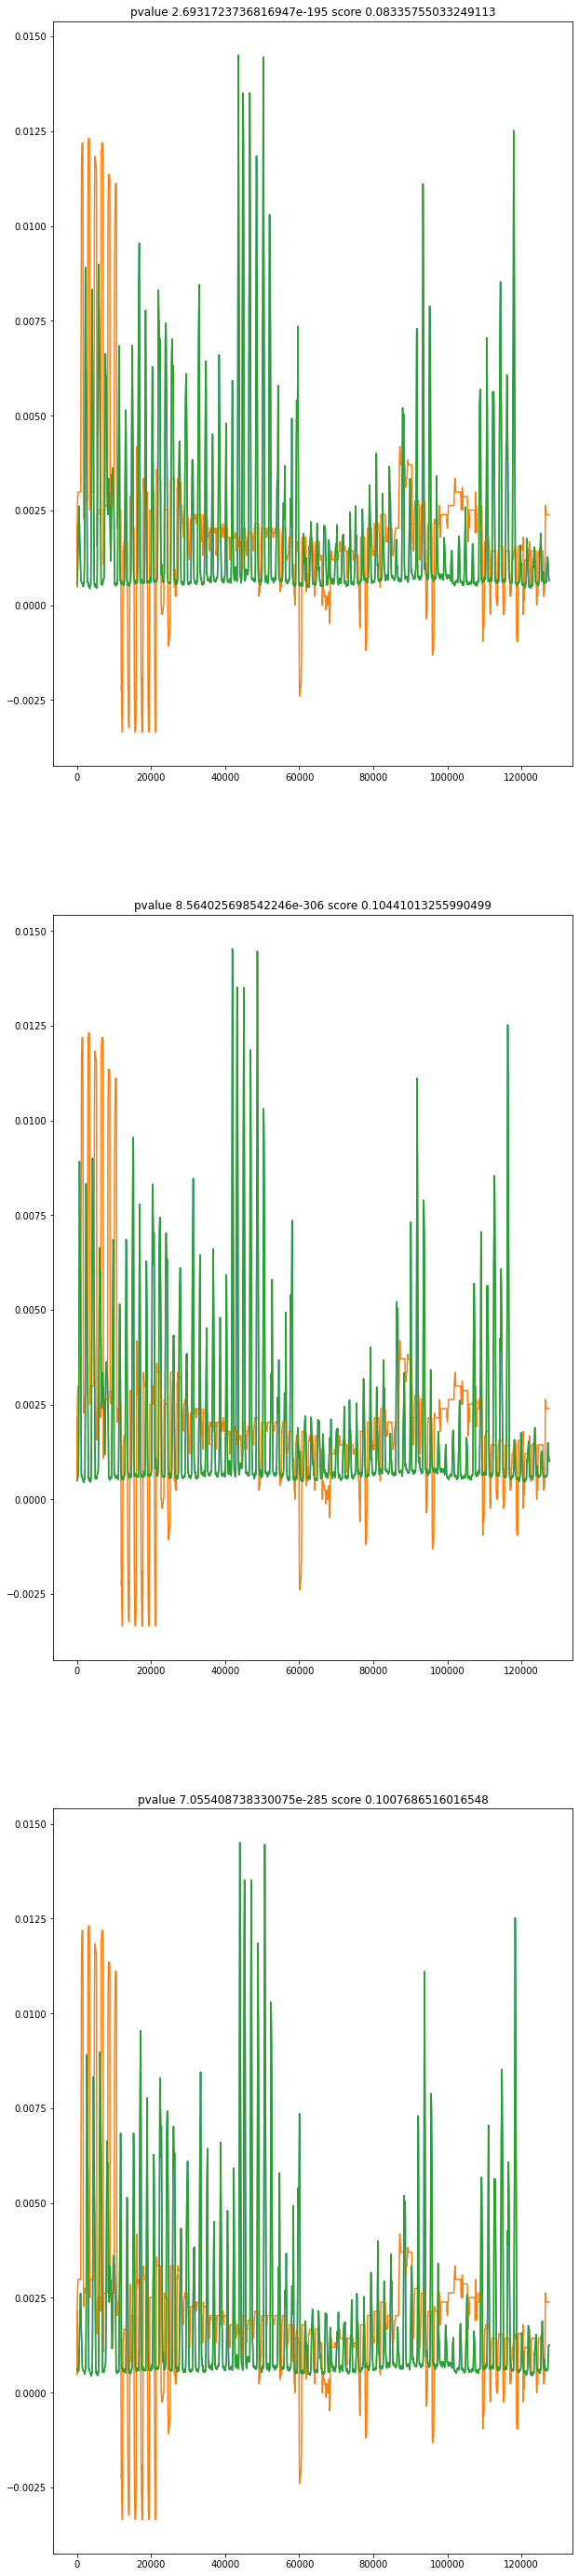

In [42]:
ch5_correlates = np.logical_and(np.abs(stats[5])<0.005,correlation[5]>0.08)
ch5_correlation = correlation[5,ch5_correlates]
ch5_stats = stats[5,ch5_correlates]
ch5_power = power[:,ch5_correlates]
plt.figure(figsize = [10,5*10])
ch5_correlated_sources = power[:,ch5_correlates]
ncorrelates = sum(ch5_correlates)
if ncorrelates>10:
    ncorrelates = 10
for i in range(ncorrelates):
    plt.subplot(ncorrelates,1,i+1)
    i+=0
    plt.plot(ch5_correlated_sources[:,i])
    plt.plot(gloves[:,5])
    plt.plot(ch5_power[:,i])
    plt.title(f'pvalue {ch5_stats[i]} score {ch5_correlation[i]}')

In [41]:
max(correlation[5])

0.10441013255990499